In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 291 µs (started: 2023-12-12 10:46:21 +00:00)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

time: 3.62 s (started: 2023-12-12 10:46:21 +00:00)


In [3]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 22.8 ms (started: 2023-12-12 10:46:25 +00:00)


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


time: 481 µs (started: 2023-12-12 10:46:25 +00:00)


In [5]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

Files already downloaded and verified
time: 10.4 s (started: 2023-12-12 10:46:25 +00:00)


In [6]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

time: 5.06 ms (started: 2023-12-12 10:46:35 +00:00)


In [7]:

cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 525 ms (started: 2023-12-12 10:46:35 +00:00)


In [8]:

cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 385 ms (started: 2023-12-12 10:46:36 +00:00)


In [9]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

time: 674 µs (started: 2023-12-12 10:46:36 +00:00)


In [10]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 344 µs (started: 2023-12-12 10:46:36 +00:00)


In [11]:
print(torch.__version__)


2.1.0+cu118
time: 356 µs (started: 2023-12-12 10:46:36 +00:00)


In [12]:
import datetime

time: 290 µs (started: 2023-12-12 10:46:36 +00:00)


In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))



time: 898 µs (started: 2023-12-12 10:46:36 +00:00)


In [14]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x


time: 564 µs (started: 2023-12-12 10:46:36 +00:00)


time: 17 ms (started: 2023-12-12 10:46:36 +00:00)


In [15]:
import torch.nn.functional as F


time: 235 µs (started: 2023-12-12 10:46:36 +00:00)


In [16]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out



time: 655 µs (started: 2023-12-12 10:46:36 +00:00)


time: 7.97 s (started: 2023-12-12 10:46:36 +00:00)


In [17]:
device

device(type='cuda')

time: 2.02 ms (started: 2023-12-12 10:46:45 +00:00)


In [18]:
model = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-12 10:47:06.135530 Epoch 1, Training loss 1.5790970384197516
2023-12-12 10:47:22.333087 Epoch 2, Training loss 1.2757431460128559
2023-12-12 10:47:53.154459 Epoch 4, Training loss 1.0664658080059524
2023-12-12 10:48:24.100999 Epoch 6, Training loss 0.9422920360369935
2023-12-12 10:48:55.035614 Epoch 8, Training loss 0.8625202439034206
2023-12-12 10:49:25.594854 Epoch 10, Training loss 0.8010393645392727
2023-12-12 10:49:56.665333 Epoch 12, Training loss 0.7496834203972698
2023-12-12 10:50:28.224389 Epoch 14, Training loss 0.7033575898416516
2023-12-12 10:50:58.680209 Epoch 16, Training loss 0.6660753198144379
2023-12-12 10:51:29.023902 Epoch 18, Training loss 0.6298215005425254
2023-12-12 10:51:59.468437 Epoch 20, Training loss 0.5918687623392216
2023-12-12 10:52:30.093259 Epoch 22, Training loss 0.5632473225499756
2023-12-12 10:53:00.385547 Epoch 24, Training loss 0.5314390877463158
2023-12-12 10:53:30.663658 Epoch 26, Training loss 0.5029496875754245
2023-12-12 10:54:01.43216

In [19]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
def validate(model, train_loader, val_loader):
    accdict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict, predictions, exp_labels


time: 1.2 ms (started: 2023-12-12 12:02:55 +00:00)


In [20]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.67
time: 17.3 s (started: 2023-12-12 12:02:55 +00:00)


In [21]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)

time: 151 ms (started: 2023-12-12 12:03:13 +00:00)


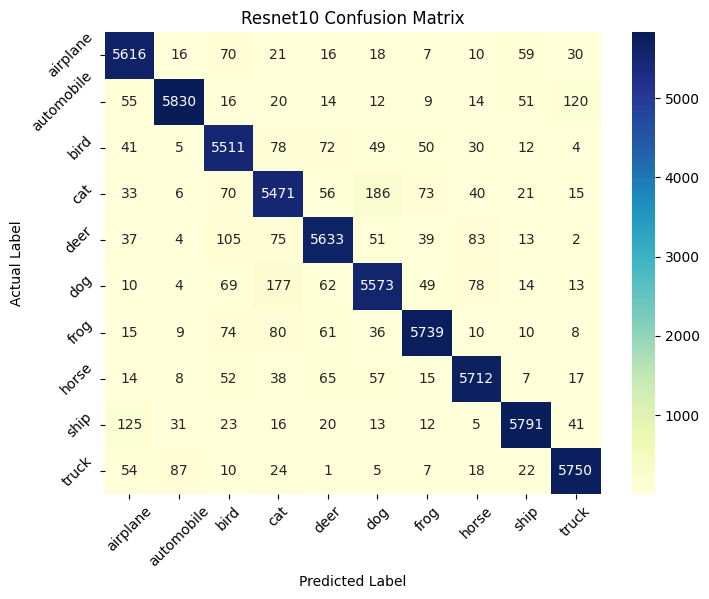

time: 444 ms (started: 2023-12-12 12:03:13 +00:00)


In [22]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [23]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.94      0.96      0.95      5863
  automobile       0.97      0.95      0.96      6141
        bird       0.92      0.94      0.93      5852
         cat       0.91      0.92      0.91      5971
        deer       0.94      0.93      0.94      6042
         dog       0.93      0.92      0.93      6049
        frog       0.96      0.95      0.95      6042
       horse       0.95      0.95      0.95      5985
        ship       0.97      0.95      0.96      6077
       truck       0.96      0.96      0.96      5978

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

time: 141 ms (started: 2023-12-12 12:03:13 +00:00)


time: 148 ms (started: 2023-12-12 12:03:13 +00:00)


In [24]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


time: 717 µs (started: 2023-12-12 12:03:13 +00:00)


In [25]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


time: 639 µs (started: 2023-12-12 12:03:13 +00:00)


In [27]:
model_wd = NetWidth(n_chans1=32).to(device=device)
optimizer_wd = optim.SGD(model_wd.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop_l2reg(
    n_epochs = 300,
    optimizer = optimizer_wd,
    model = model_wd,
    loss_fn = loss_fn,
    train_loader = train_loader,
)



2023-12-12 12:03:43.329008 Epoch 1, Training loss 1.9939807186955991
2023-12-12 12:05:54.987212 Epoch 10, Training loss 1.160557784235386
2023-12-12 12:08:21.225743 Epoch 20, Training loss 0.9642956210371784
2023-12-12 12:10:47.389704 Epoch 30, Training loss 0.8923261045952282
2023-12-12 12:13:14.563115 Epoch 40, Training loss 0.8513407973224855
2023-12-12 12:15:41.806490 Epoch 50, Training loss 0.8239225297785171
2023-12-12 12:18:09.297921 Epoch 60, Training loss 0.8045251942656534
2023-12-12 12:20:34.436626 Epoch 70, Training loss 0.7900362135961537
2023-12-12 12:23:00.929913 Epoch 80, Training loss 0.7787863984132362
2023-12-12 12:25:27.097327 Epoch 90, Training loss 0.769704382818983
2023-12-12 12:27:54.276961 Epoch 100, Training loss 0.7624059809595728
2023-12-12 12:30:21.542585 Epoch 110, Training loss 0.7563693132394415
2023-12-12 12:32:47.720628 Epoch 120, Training loss 0.7512598533916961
2023-12-12 12:35:14.701207 Epoch 130, Training loss 0.7469299924190697
2023-12-12 12:37:40

In [28]:
accuracy_wd, predictions_wd, expected_labels_wd = validate(model_wd, train_loader, val_loader)

Accuracy train: 0.85
Accuracy val: 0.68
time: 15.8 s (started: 2023-12-12 13:17:30 +00:00)


In [29]:
precision_wd = precision_score(predictions_wd, expected_labels_wd, average='macro')
recall_wd = recall_score(predictions_wd, expected_labels_wd, average='macro')
cnf_matrix_wd = confusion_matrix(predictions_wd, expected_labels_wd)

time: 151 ms (started: 2023-12-12 13:18:16 +00:00)


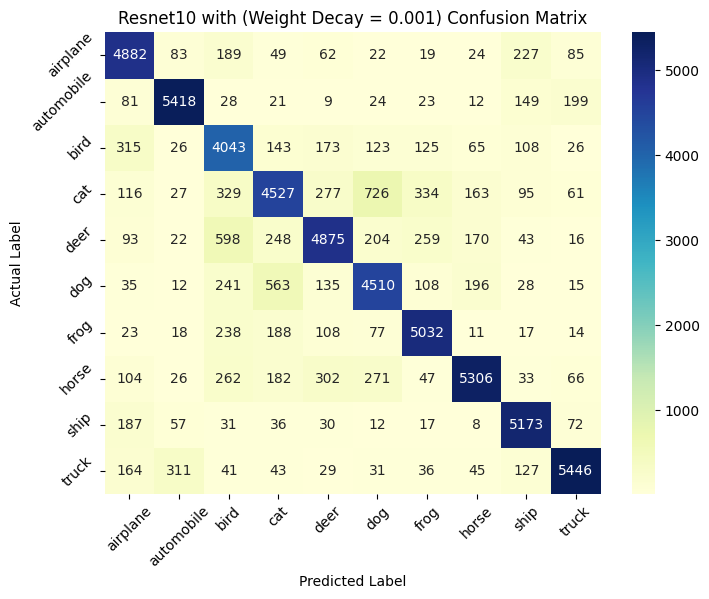

time: 405 ms (started: 2023-12-12 13:19:09 +00:00)


In [30]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_wd, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 with (Weight Decay = 0.001) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [31]:
print(classification_report(predictions_wd, expected_labels_wd, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.81      0.87      0.84      5642
  automobile       0.90      0.91      0.91      5964
        bird       0.67      0.79      0.73      5147
         cat       0.75      0.68      0.72      6655
        deer       0.81      0.75      0.78      6528
         dog       0.75      0.77      0.76      5843
        frog       0.84      0.88      0.86      5726
       horse       0.88      0.80      0.84      6599
        ship       0.86      0.92      0.89      5623
       truck       0.91      0.87      0.89      6273

    accuracy                           0.82     60000
   macro avg       0.82      0.82      0.82     60000
weighted avg       0.82      0.82      0.82     60000

time: 136 ms (started: 2023-12-12 13:19:33 +00:00)


In [34]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 846 µs (started: 2023-12-12 13:25:01 +00:00)


In [35]:
model_dropout = NetDropout(n_chans1=32).to(device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer_dropout,
    model = model_dropout,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-12 13:25:19.680313 Epoch 1, Training loss 2.0097830361112607
2023-12-12 13:25:34.325807 Epoch 2, Training loss 1.7803532046735133
2023-12-12 13:26:03.245799 Epoch 4, Training loss 1.5596976769549766
2023-12-12 13:26:32.091412 Epoch 6, Training loss 1.4576420965402022
2023-12-12 13:27:01.072646 Epoch 8, Training loss 1.38476528200652
2023-12-12 13:27:29.609623 Epoch 10, Training loss 1.3333351811027283
2023-12-12 13:27:57.346893 Epoch 12, Training loss 1.2905683922950568
2023-12-12 13:28:25.343734 Epoch 14, Training loss 1.2506993476996946
2023-12-12 13:28:52.999487 Epoch 16, Training loss 1.2271902818813958
2023-12-12 13:29:20.793370 Epoch 18, Training loss 1.199903026566176
2023-12-12 13:29:48.270420 Epoch 20, Training loss 1.1831524830949887
2023-12-12 13:30:16.029670 Epoch 22, Training loss 1.1644683083152527
2023-12-12 13:30:43.787693 Epoch 24, Training loss 1.1487101951371068
2023-12-12 13:31:11.746930 Epoch 26, Training loss 1.1307556485885855
2023-12-12 13:31:39.501297 E

In [36]:
accuracy_dropout, predictions_dropout, expected_labels_dropout = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.69
Accuracy val: 0.62
time: 14.7 s (started: 2023-12-12 14:34:41 +00:00)


In [37]:
precision_dropout = precision_score(predictions_dropout, expected_labels_dropout, average='macro')
recall_dropout = recall_score(predictions_dropout, expected_labels_dropout, average='macro')
cnf_matrix_dropout = confusion_matrix(predictions_dropout, expected_labels_dropout)

time: 149 ms (started: 2023-12-12 14:34:55 +00:00)


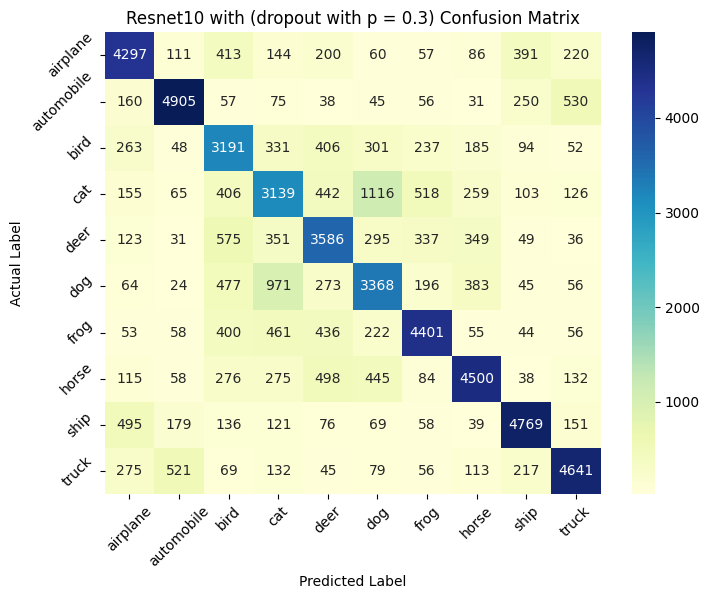

time: 406 ms (started: 2023-12-12 14:34:56 +00:00)


In [38]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_dropout, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 with (dropout with p = 0.3) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [39]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      5979
  automobile       0.82      0.80      0.81      6147
        bird       0.53      0.62      0.57      5108
         cat       0.52      0.50      0.51      6329
        deer       0.60      0.63      0.61      5732
         dog       0.56      0.58      0.57      5857
        frog       0.73      0.71      0.72      6186
       horse       0.75      0.70      0.72      6421
        ship       0.79      0.78      0.79      6093
       truck       0.77      0.75      0.76      6148

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

time: 134 ms (started: 2023-12-12 14:52:47 +00:00)


In [40]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


time: 856 µs (started: 2023-12-12 14:52:53 +00:00)


In [42]:
model_batch_norm = NetBatchNorm(n_chans1=32).to(device=device)
optimizer_batch_norm = optim.SGD(model_batch_norm.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer_batch_norm,
    model = model_batch_norm,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-12 14:54:16.964874 Epoch 1, Training loss 1.7979085021616552
2023-12-12 14:54:31.589961 Epoch 2, Training loss 1.4637582832590088
2023-12-12 14:54:59.820735 Epoch 4, Training loss 1.228781066282326
2023-12-12 14:55:28.471342 Epoch 6, Training loss 1.1067761255956976
2023-12-12 14:55:56.583463 Epoch 8, Training loss 1.0284692133631548
2023-12-12 14:56:24.816715 Epoch 10, Training loss 0.9709521866667911
2023-12-12 14:56:52.810036 Epoch 12, Training loss 0.9238295592462925
2023-12-12 14:57:20.902723 Epoch 14, Training loss 0.8835189616893564
2023-12-12 14:57:48.572475 Epoch 16, Training loss 0.84901308746594
2023-12-12 14:58:16.614381 Epoch 18, Training loss 0.8195060453451503
2023-12-12 14:58:44.443190 Epoch 20, Training loss 0.7933901263319928
2023-12-12 14:59:12.381190 Epoch 22, Training loss 0.7701474607295697
2023-12-12 14:59:40.260873 Epoch 24, Training loss 0.7490701191413128
2023-12-12 15:00:08.038122 Epoch 26, Training loss 0.729625809146925
2023-12-12 15:00:35.638639 Ep

In [43]:
accuracy_batch_norm, predictions_batch_norm, expected_labels_batch_norm = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.70
Accuracy val: 0.62
time: 15.2 s (started: 2023-12-12 16:38:57 +00:00)


In [44]:
precision_batch_norm = precision_score(predictions_batch_norm, expected_labels_batch_norm, average='macro')
recall_batch_norm = recall_score(predictions_batch_norm, expected_labels_batch_norm, average='macro')
cnf_matrix_batch_norm = confusion_matrix(predictions_batch_norm, expected_labels_batch_norm)

time: 150 ms (started: 2023-12-12 16:39:12 +00:00)


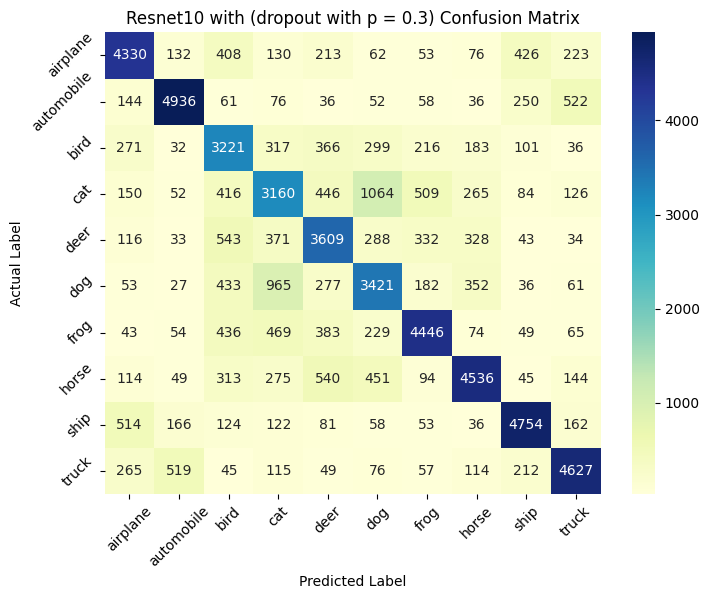

time: 414 ms (started: 2023-12-12 16:39:12 +00:00)


In [45]:
# Creating the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_batch_norm, annot=True, cmap="YlGnBu", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 with (dropout with p = 0.3) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [46]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      5979
  automobile       0.82      0.80      0.81      6147
        bird       0.53      0.62      0.57      5108
         cat       0.52      0.50      0.51      6329
        deer       0.60      0.63      0.61      5732
         dog       0.56      0.58      0.57      5857
        frog       0.73      0.71      0.72      6186
       horse       0.75      0.70      0.72      6421
        ship       0.79      0.78      0.79      6093
       truck       0.77      0.75      0.76      6148

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

time: 137 ms (started: 2023-12-12 16:39:22 +00:00)
